In [1]:
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, TensorDataset
from src.supervised import AudioDataset, AudioMobileNetV2, AudioBiLSTM, AudioTransformer, train, eval, save_model

from src.audio_preprocessing import *
from src.sparse_transition_vae import SparseTransitionVAE
from src.clustering import clustering_predicting, signal_visualization, cluster_visualization, clustering_evaluatation

In [2]:
# Audio loading
audio_path = "data"
annotation_path = "labels"

audio_files = load_files(audio_path, ".wav")
annotation_files = load_files(annotation_path, ".TextGrid")

In [3]:
# Maximum signal length
max_length = max_signal_length(audio_files)
# Fbank features extraction
X = fbank_features_extraction(audio_files, max_length, num_features=40)

100%|██████████| 457/457 [00:08<00:00, 54.92it/s]


In [4]:
# Check the shape of Input
X.shape

(457, 703, 41)

In [5]:
# Spectrogram Plotting
def plot_spectrogram(spec, note):
    fig = plt.figure(figsize=(20, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Time(s)')
    plt.ylabel(note)
    plt.tight_layout()

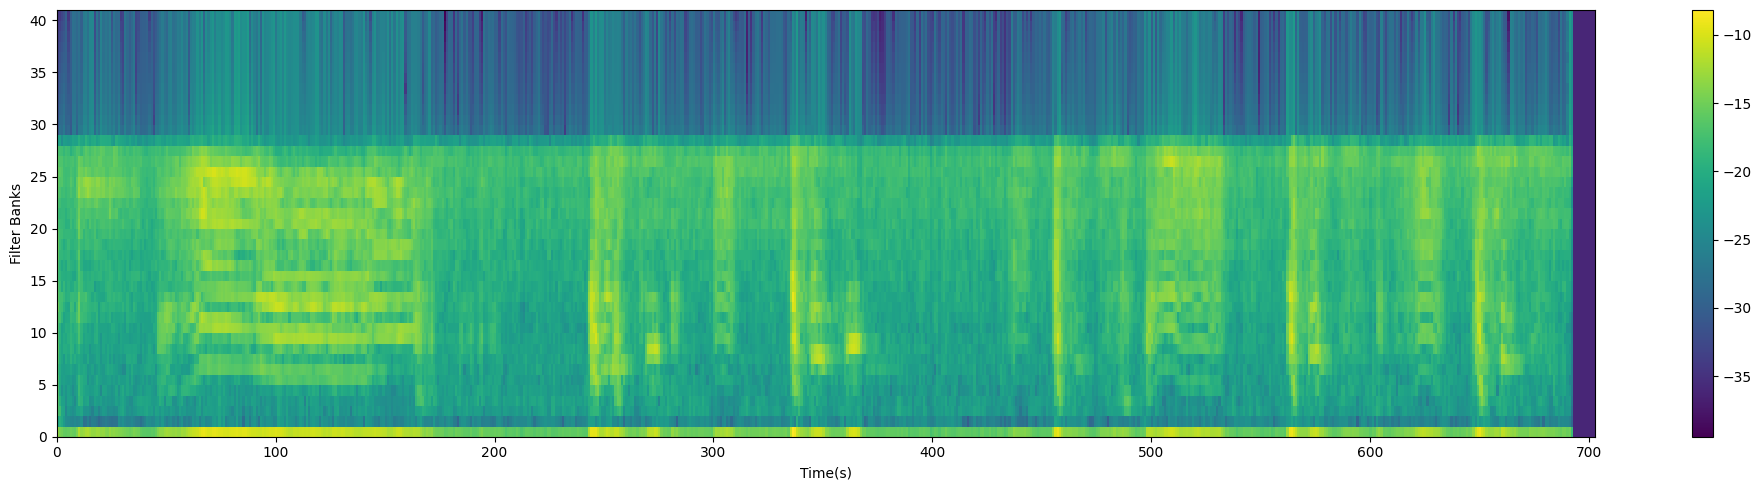

In [6]:
plot_spectrogram(X[0].T, 'Filter Banks')

In [7]:
# Data Preparation
X = torch.tensor(X, dtype=torch.float32)
X_train, X_test = train_test_split(X, test_size=0.2)

train_dataset, test_dataset = TensorDataset(X_train), TensorDataset(X_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Model instantiation
input_dim = 41 # num_feature
latent_dim = 2
hidden_dim = 128
model = SparseTransitionVAE(input_dim, latent_dim, hidden_dim)

In [9]:
# Model Architecture
print(model)

SparseTransitionVAE(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=2, bias=True)
  (transition_fn): LSTM(2, 2, num_layers=2, batch_first=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=41, bias=True)
  )
)


In [10]:
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# define cosine decay
T_0 = 10  # Initial number of epochs for the first restart
T_mult = 2  # Multiplicative factor by which the number of epochs for every subsequent restarts increases
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0

    for batch_idx, X_batch in enumerate(train_loader):  # Assuming you have a DataLoader
        optimizer.zero_grad() 
        # Forward pass
        for X_sub in X_batch:
            X_recon, Z, U_next, loss = model(X_sub)
        # Total loss
        total_loss = loss
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()

    # Print average loss for the epoch
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 10/100, Loss: 27773406.1667
Epoch 20/100, Loss: 11666606.4167
Epoch 30/100, Loss: 6001329.1250
Epoch 40/100, Loss: 4828598.5312
Epoch 50/100, Loss: 4337872.5625
Epoch 60/100, Loss: 3950804.5104
Epoch 70/100, Loss: 3712797.8333
Epoch 80/100, Loss: 3848789.2604
Epoch 90/100, Loss: 3401795.0729
Epoch 100/100, Loss: 3337983.9271


In [11]:
# Testing phase
model.eval()
test_loss = 0
with torch.no_grad():  # No need to track gradients during evaluation
    for X_batch in test_loader:
        # Forward pass
        for X_sub in X_batch:
            X_recon, Z, U_next, loss = model(X_sub)
        # Total loss
        total_loss = loss
        test_loss += total_loss.item()

# Print average test loss
print(f"\nTest Loss: {test_loss / len(test_loader):.4f}")


Test Loss: 3397086.5833


In [12]:
# Latent Variable Cluster
# Get latent variable
X_recon, Z, U_next, loss = model(X)

In [13]:
def validation_domain_index(data, threshold):
    return [i for i, value in enumerate(data) if value > threshold]

In [14]:
acc_list, framef_list, eventf_list, iou_list, switch_list = clustering_evaluatation(model, max_length, audio_files, annotation_files, clustering_method="kmeans", k=2)

100%|██████████| 1/1 [00:00<00:00, 28.92it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 41.59it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 52.56it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn

In [15]:
print("(KMeans, k=2)")
print(f"Frame-based Accuracy: {np.mean(acc_list)}")
print(f"Frame-based F1 score: {np.mean(framef_list)}")
print(f"Event-based F1 score: {np.mean(eventf_list)}")
print(f"Event-based IOU: {np.mean(iou_list)}")

(KMeans, k=2)
Frame-based Accuracy: 0.7478769424676742
Frame-based F1 score: 0.6920742994957588
Event-based F1 score: 0.13880708704986705
Event-based IOU: 0.06752542651752241


In [16]:
domain_index = validation_domain_index(eventf_list, threshold=0.6)
print(f"domain length: {len(domain_index)}")

domain length: 54


In [17]:
acc_list, framef_list, eventf_list, iou_list, switch_list = clustering_evaluatation(model, max_length, audio_files, annotation_files, domain_index, clustering_method="kmeans", k=2)

100%|██████████| 1/1 [00:00<00:00, 50.87it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 56.87it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 52.09it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn

In [18]:
print("(KMeans, k=2)")
print(f"Frame-based Accuracy: {np.mean(acc_list)}")
print(f"Frame-based F1 score: {np.mean(framef_list)}")
print(f"Event-based F1 score: {np.mean(eventf_list)}")
print(f"Event-based IOU: {np.mean(iou_list)}")

(KMeans, k=2)
Frame-based Accuracy: 0.9047748711627484
Frame-based F1 score: 0.890213763055445
Event-based F1 score: 0.8778492325877947
Event-based IOU: 0.4646504288325943


In [19]:
acc_list, framef_list, eventf_list, iou_list, switch_list = clustering_evaluatation(model, max_length, audio_files, annotation_files, domain_index, clustering_method="kmeans", k=4)

100%|██████████| 1/1 [00:00<00:00, 60.07it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 60.30it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 57.72it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn

In [20]:
print("(KMeans, k=4)")
print(f"Frame-based Accuracy: {np.mean(acc_list)}")
print(f"Frame-based F1 score: {np.mean(framef_list)}")
print(f"Event-based F1 score: {np.mean(eventf_list)}")
print(f"Event-based IOU: {np.mean(iou_list)}")

(KMeans, k=4)
Frame-based Accuracy: 0.6849609497210559
Frame-based F1 score: 0.791862146890897
Event-based F1 score: 0.7109404666752336
Event-based IOU: 0.5200865205440576


In [21]:
acc_list, framef_list, eventf_list, iou_list, switch_list = clustering_evaluatation(model, max_length, audio_files, annotation_files, domain_index, clustering_method="kmeans", k=6)

100%|██████████| 1/1 [00:00<00:00, 60.47it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 62.10it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 61.84it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn

In [22]:
print("(KMeans, k=6)")
print(f"Frame-based Accuracy: {np.mean(acc_list)}")
print(f"Frame-based F1 score: {np.mean(framef_list)}")
print(f"Event-based F1 score: {np.mean(eventf_list)}")
print(f"Event-based IOU: {np.mean(iou_list)}")

(KMeans, k=6)
Frame-based Accuracy: 0.6458591620469404
Frame-based F1 score: 0.7393596414423637
Event-based F1 score: 0.5233461942827269
Event-based IOU: 0.5641907673788221


In [23]:
acc_list, framef_list, eventf_list, iou_list, switch_list = clustering_evaluatation(model, max_length, audio_files, annotation_files, domain_index, clustering_method="mean_shift")

100%|██████████| 1/1 [00:00<00:00, 64.35it/s]


In [24]:
print("(Mean-shift)")
print(f"Frame-based Accuracy: {np.mean(acc_list)}")
print(f"Frame-based F1 score: {np.mean(framef_list)}")
print(f"Event-based F1 score: {np.mean(eventf_list)}")
print(f"Event-based IOU: {np.mean(iou_list)}")

(Mean-shift)
Frame-based Accuracy: 0.7653930806050957
Frame-based F1 score: 0.7571360705370657
Event-based F1 score: 0.6364024186263607
Event-based IOU: 0.3524263450988168


In [25]:
acc_list, framef_list, eventf_list, iou_list, switch_list = clustering_evaluatation(model, max_length, audio_files, annotation_files, domain_index, clustering_method="bisecting", k=2)

100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


In [26]:
print("(Bisecting)")
print(f"Frame-based Accuracy: {np.mean(acc_list)}")
print(f"Frame-based F1 score: {np.mean(framef_list)}")
print(f"Event-based F1 score: {np.mean(eventf_list)}")
print(f"Event-based IOU: {np.mean(iou_list)}")

(Bisecting)
Frame-based Accuracy: 0.8894266971293818
Frame-based F1 score: 0.8832196079001732
Event-based F1 score: 0.6124506152283928
Event-based IOU: 0.2580826727424749


In [27]:
X, y = supervised_features_extraction(audio_files, annotation_files, max_length, domain_index, num_features=40)

100%|██████████| 54/54 [00:02<00:00, 18.20it/s]


In [28]:
# Data preparation
batch_size = 4
dataset = AudioDataset(X, y)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [29]:
# Training phase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = AudioMobileNetV2()
model_1.to(device)
train(model_1, train_loader, device)

c:\Users\ECCSH\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ECCSH\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.3889185447584499, LR: 0.0009755282581475768
Epoch 2/10, Loss: 0.24748445911840958, LR: 0.0009045084971874736
Epoch 3/10, Loss: 0.2632825645533475, LR: 0.0007938926261462366
Epoch 4/10, Loss: 0.22921097549525174, LR: 0.0006545084971874737
Epoch 5/10, Loss: 0.21769814328713852, LR: 0.0005
Epoch 6/10, Loss: 0.19488216665658084, LR: 0.00034549150281252633
Epoch 7/10, Loss: 0.2149220583113757, LR: 0.0002061073738537635
Epoch 8/10, Loss: 0.2022604705257849, LR: 9.549150281252634e-05
Epoch 9/10, Loss: 0.17100585726174442, LR: 2.4471741852423235e-05
Epoch 10/10, Loss: 0.19297013838182797, LR: 0.0


In [30]:
# Save model
mobilenet_path = 'models/AudioMobileNetV2.pth'
save_model(model_1, mobilenet_path)

Model saved to models/AudioMobileNetV2.pth


In [31]:
# Evaluate on test set
acc_list, framef_list, eventf_list, iou_list = eval(model_1, test_loader, device)
frame_accuracy = np.mean(acc_list)
frame_f = np.mean(framef_list)
event_f = np.mean(eventf_list)
event_iou = np.mean(iou_list)
print(f"Frame-based accuracy: {frame_accuracy}")
print(f"Frame-based f1 score: {frame_f}")
print(f"Event-based f1 score: {event_f}")
print(f"Event-based iou: {event_iou}")

Frame-based accuracy: 0.9389125968073336
Frame-based f1 score: 0.9372639378483104
Event-based f1 score: 0.9914529914529915
Event-based iou: 0.3478280682127966


In [32]:
model_2 = AudioBiLSTM(num_features=41)
model_2.to(device)
train(model_2, train_loader, device)

Epoch 1/10, Loss: 0.48396180299195374, LR: 0.0009755282581475768
Epoch 2/10, Loss: 0.3196861215613105, LR: 0.0009045084971874736
Epoch 3/10, Loss: 0.2350843088193373, LR: 0.0007938926261462366
Epoch 4/10, Loss: 0.21945799616250125, LR: 0.0006545084971874737
Epoch 5/10, Loss: 0.20382967455820603, LR: 0.0005
Epoch 6/10, Loss: 0.19316897879947315, LR: 0.00034549150281252633
Epoch 7/10, Loss: 0.1846991154280576, LR: 0.0002061073738537635
Epoch 8/10, Loss: 0.17879310318014838, LR: 9.549150281252634e-05
Epoch 9/10, Loss: 0.1802773130210963, LR: 2.4471741852423235e-05
Epoch 10/10, Loss: 0.17086605524474924, LR: 0.0


In [33]:
# Specify the path where you want to save the model
bilstm_path = 'models/AudioBiLSTM.pth'
# Save the trained model
save_model(model_2, bilstm_path)

Model saved to models/AudioBiLSTM.pth


In [34]:
acc_list, framef_list, eventf_list, iou_list = eval(model_2, test_loader, device)
frame_accuracy = np.mean(acc_list)
frame_f = np.mean(framef_list)
event_f = np.mean(eventf_list)
event_iou = np.mean(iou_list)
print(f"Frame-based accuracy: {frame_accuracy}")
print(f"Frame-based f1 score: {frame_f}")
print(f"Event-based f1 score: {event_f}")
print(f"Event-based iou: {event_iou}")

Frame-based accuracy: 0.964556661925083
Frame-based f1 score: 0.9655360112285675
Event-based f1 score: 0.9648148148148148
Event-based iou: 0.7629334536450832


In [35]:
model_3 = AudioTransformer(input_dim=41)
model_3.to(device)
train(model_3, train_loader, device)

Epoch 1/10, Loss: 0.7826308012008667, LR: 0.0009755282581475768
Epoch 2/10, Loss: 0.464744659987363, LR: 0.0009045084971874736
Epoch 3/10, Loss: 0.33116671307520434, LR: 0.0007938926261462366
Epoch 4/10, Loss: 0.3591795130209489, LR: 0.0006545084971874737
Epoch 5/10, Loss: 0.30301360515030945, LR: 0.0005
Epoch 6/10, Loss: 0.27371103926138446, LR: 0.00034549150281252633
Epoch 7/10, Loss: 0.2758923403241418, LR: 0.0002061073738537635
Epoch 8/10, Loss: 0.2708410173654556, LR: 9.549150281252634e-05
Epoch 9/10, Loss: 0.2465359392491254, LR: 2.4471741852423235e-05
Epoch 10/10, Loss: 0.242949940264225, LR: 0.0


In [36]:
# Specify the path where you want to save the model
transformer_path = 'models/AudioTransformer.pth'
# Save the trained model
save_model(model_3, transformer_path)

Model saved to models/AudioTransformer.pth


In [37]:
acc_list, framef_list, eventf_list, iou_list = eval(model_3, test_loader, device)
frame_accuracy = np.mean(acc_list)
frame_f = np.mean(framef_list)
event_f = np.mean(eventf_list)
event_iou = np.mean(iou_list)
print(f"Frame-based accuracy: {frame_accuracy}")
print(f"Frame-based f1 score: {frame_f}")
print(f"Event-based f1 score: {event_f}")
print(f"Event-based iou: {event_iou}")

Frame-based accuracy: 0.9226331594752647
Frame-based f1 score: 0.9221751499160625
Event-based f1 score: 0.9777777777777777
Event-based iou: 0.2608091264445451


100%|██████████| 1/1 [00:00<00:00, 39.82it/s]
c:\Users\ECCSH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


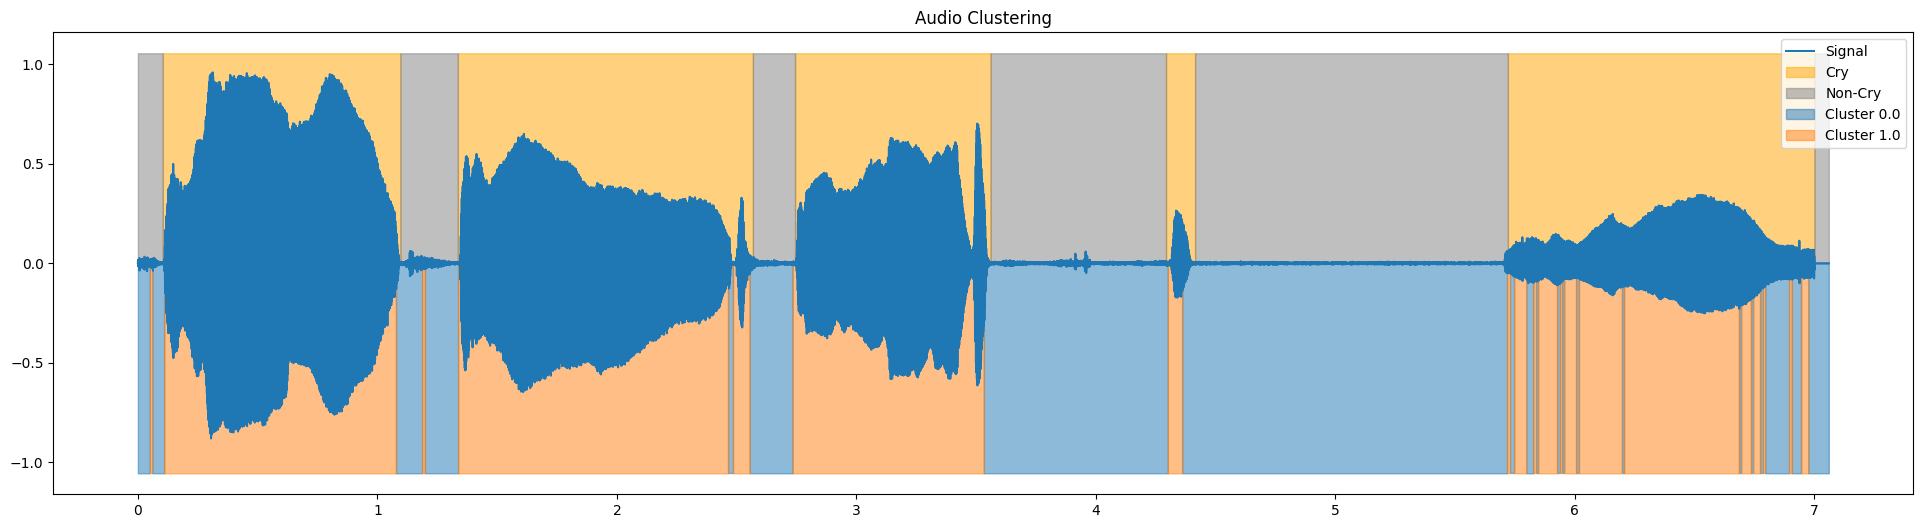

In [38]:
index = domain_index[0]
audio_file = audio_files[index]
annotation_file = annotation_files[index]
signal, fs, truth_labels, label_timeseries = clustering_predicting(model, annotation_file, audio_file, max_length, clustering_method="kmeans", k=2)
cluster_visualization(signal, fs, truth_labels, label_timeseries)

In [42]:
test_audio = fbank_features_extraction([audio_file], max_length)
test_input = torch.tensor(test_audio, dtype=torch.float32)

100%|██████████| 1/1 [00:00<00:00, 46.37it/s]


In [55]:
def signal_visualization(signal, fs, truth_labels, label_timeseries):
    # define time axis
    Ns = len(signal) # number of sample
    Ts = 1 / fs # sampling period
    t = np.arange(Ns) * Ts # time axis in seconds
    norm_coef = 1.1 * np.max(signal)
    edge_ind = np.min([signal.shape[0], len(truth_labels)])
     
    plt.figure(figsize=(24, 6))
    plt.plot(t[:edge_ind], signal[:edge_ind])
    plt.plot(t[:edge_ind], truth_labels[:edge_ind] * norm_coef)
    plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

    plt.title("Ground truth labels")
    plt.legend(['Signal', 'Ground Truth', 'Prediction'])
    plt.show()


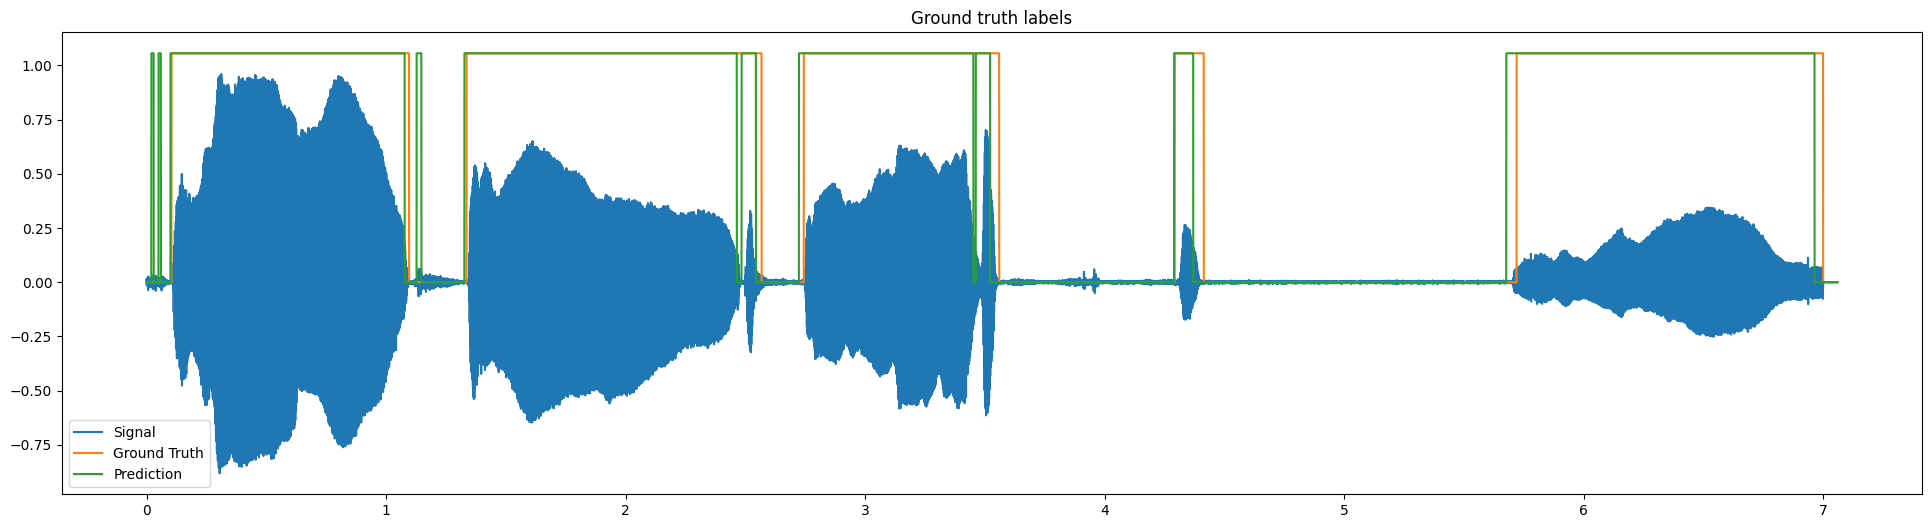

In [56]:
test_output = model_1(test_input.to(device))
test_output = test_output.view(-1)
test_pred = torch.sigmoid(test_output)
test_pred = (test_pred > 0.5).float()
test_pred = test_pred.cpu().numpy()

label_timeseries_supervised = np.zeros(max_length)
begin = int(0)
end = int(0.025 *fs)
shift_step = int(0.01 * fs)
for i in range(test_pred.shape[0]):
    label_timeseries_supervised[begin:end] = abs(test_pred[i])
    begin = begin + shift_step
    end = end + shift_step

signal_visualization(signal, fs, truth_labels, label_timeseries_supervised)